## Import event log

In [129]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [109]:
domestic_path = 'data/DomesticDeclarations.xes'
international_path = 'data/InternationalDeclarations.xes'

log= pm4py.read_xes(domestic_path);

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

## Statistical Analysis of Event Data

In [124]:
log.head(10)

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2017-01-09 08:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2017-01-09 10:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 08:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 16:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2017-01-09 09:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
5,st_step 86799_0,STAFF MEMBER,APPROVED by PRE_APPROVER,2017-02-22 09:29:21+00:00,PRE_APPROVER,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
6,st_step 86797_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2017-02-23 07:14:45+00:00,SUPERVISOR,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
7,dd_declaration 86795_19,SYSTEM,Request Payment,2017-03-06 13:07:25+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
8,dd_declaration 86795_20,SYSTEM,Payment Handled,2017-03-13 16:30:59+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
9,st_step 86804_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2017-01-09 10:13:33+00:00,EMPLOYEE,declaration 86800,declaration 86800,budget 86566,declaration number 86801,320.646137


In [146]:
# show rows where case:id not equal case:concept:name
log[log['case:id'] != log['case:concept:name']]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount


It looks like case_id and case_concept_name columns are the same.

In [111]:
# to improve readability we trim the word 'Declaration' out of concept:name column, if it exists
log['concept:name'] = log['concept:name'].str.replace('Declaration ', '')

In [145]:
# pick random case
case_ids = log['case:id'].unique()
random_case = log[log['case:id'] == np.random.choice(case_ids)]
random_case = random_case.sort_values(by='time:timestamp')
random_case

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
25109,st_step 111985_0,STAFF MEMBER,SUBMITTED by EMPLOYEE,2018-05-01 13:15:53+00:00,EMPLOYEE,declaration 111981,declaration 111981,budget 86566,declaration number 111982,23.696543
25110,st_step 111983_0,STAFF MEMBER,APPROVED by ADMINISTRATION,2018-05-01 13:16:16+00:00,ADMINISTRATION,declaration 111981,declaration 111981,budget 86566,declaration number 111982,23.696543
25111,st_step 111984_0,STAFF MEMBER,FINAL_APPROVED by SUPERVISOR,2018-05-01 13:47:09+00:00,SUPERVISOR,declaration 111981,declaration 111981,budget 86566,declaration number 111982,23.696543
25112,dd_declaration 111981_19,SYSTEM,Request Payment,2018-05-03 07:11:20+00:00,UNDEFINED,declaration 111981,declaration 111981,budget 86566,declaration number 111982,23.696543
25113,dd_declaration 111981_20,SYSTEM,Payment Handled,2018-05-07 15:31:13+00:00,UNDEFINED,declaration 111981,declaration 111981,budget 86566,declaration number 111982,23.696543


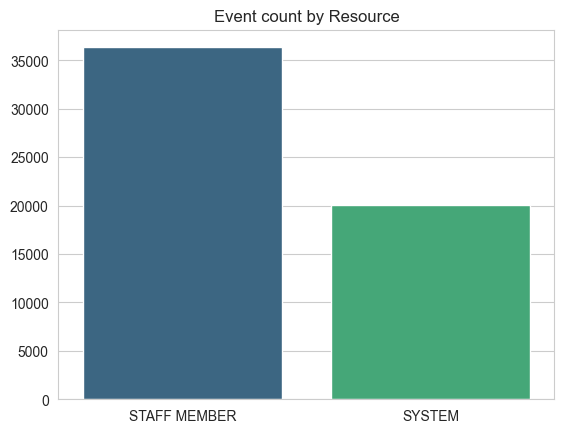

In [113]:
resources = log['org:resource'].unique()
sns.countplot(x='org:resource', data=log, palette='viridis').set(title='Event count by Resource', xlabel='', ylabel='');

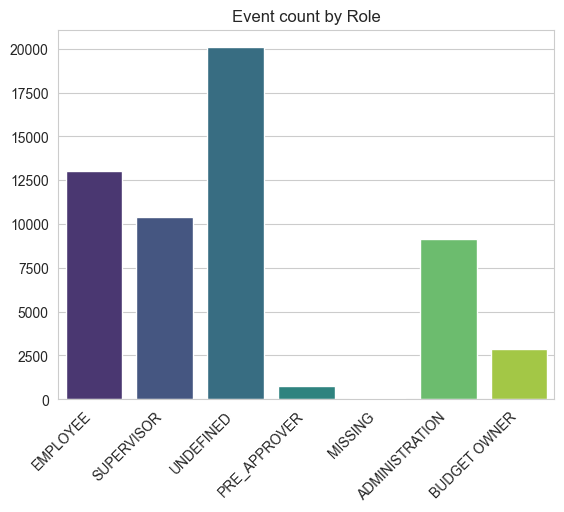

In [114]:
roles = log['org:role'].unique()
sns.countplot(x='org:role', data=log, palette='viridis').set(title='Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

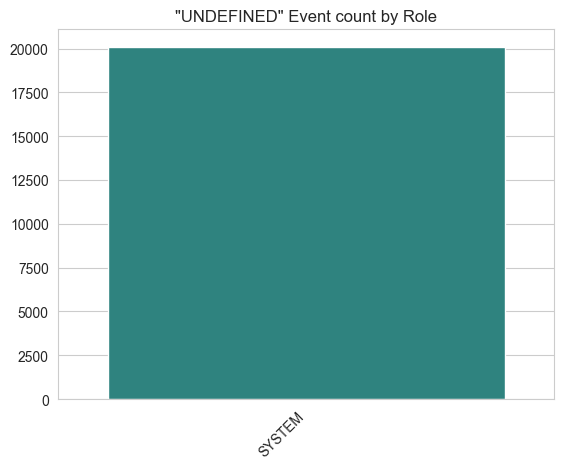

In [115]:
log_i = log[log['org:role'] == 'UNDEFINED']
sns.countplot(x='org:resource', data=log_i, palette='viridis').set(title='"UNDEFINED" Event count by Role', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

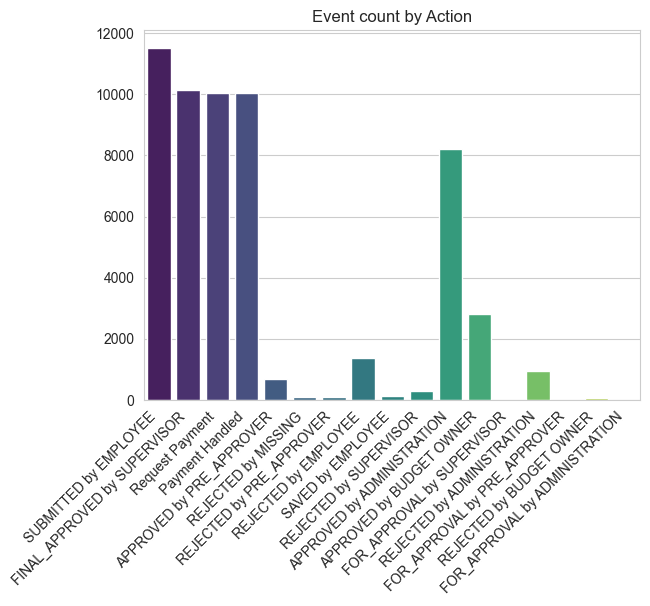

In [116]:
actions = log['concept:name'].unique()
sns.countplot(x='concept:name', data=log, palette='viridis').set(title='Event count by Action', xlabel='', ylabel='')
plt.xticks(rotation=45, ha='right');

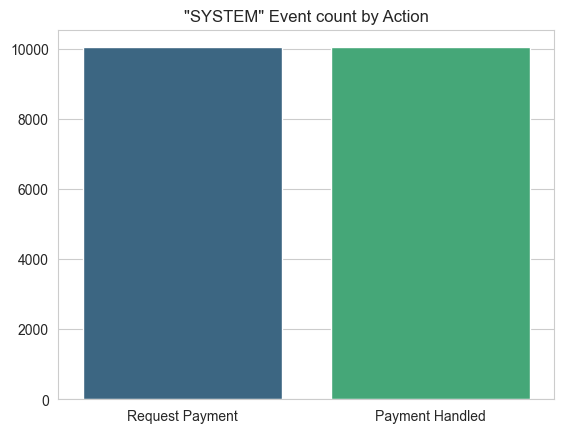

In [117]:
# System Events
log_s = log[log['org:resource'] == 'SYSTEM']
sns.countplot(x='concept:name', data=log_s, palette='viridis').set(title='"SYSTEM" Event count by Action', xlabel='', ylabel='');

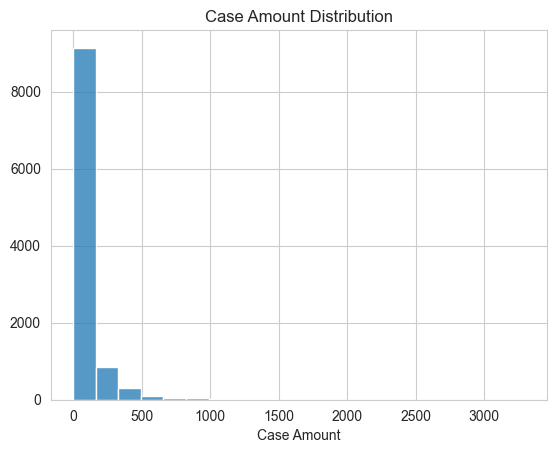

In [118]:
# case amount distribution for distinct case:id
distinct_case_amounts = log.groupby('case:id')['case:Amount'].max()
sns.histplot(distinct_case_amounts, kde=False, bins=20).set(title='Case Amount Distribution', xlabel='Case Amount', ylabel='');

## Process Discovery

Having mined the model we may vizualize it as a Process Tree or Petri Net.

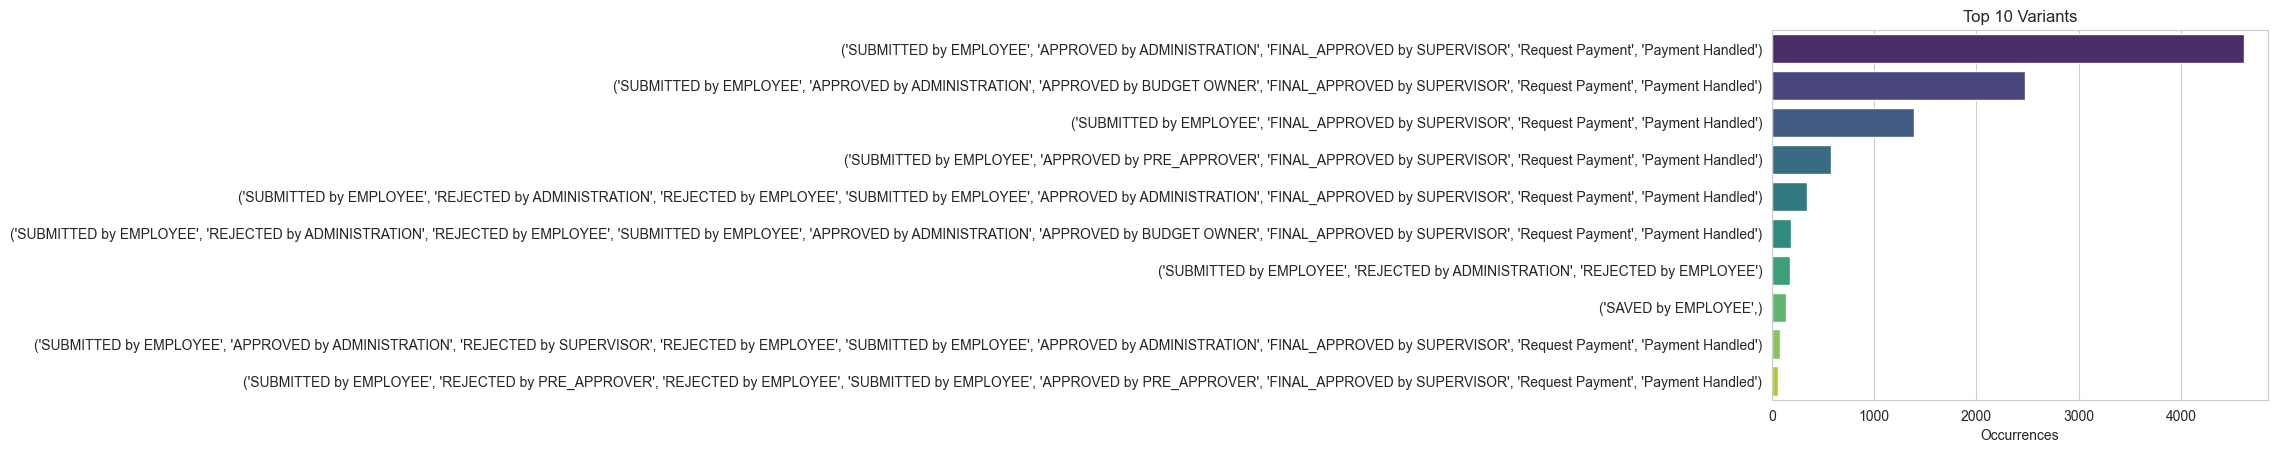

In [119]:
variants_dict = pm4py.get_variants(log)

variants_arr = []
idx = 1
for variant, n in variants_dict.items():
    variant_in_dict = {}
    variant_in_dict['variant_number'] = idx
    variant_in_dict['variant_count'] = n
    variant_in_dict['variant_trace'] = variant
    
    variants_arr.append(variant_in_dict)
    
    idx += 1


variants_df = pd.DataFrame(variants_arr)
variants_df = variants_df.sort_values(by='variant_count', ascending=False)

sns.barplot(x='variant_count', y='variant_trace', data=variants_df[:10], palette='viridis').set(title='Top 10 Variants', xlabel='Occurrences', ylabel='');

In [120]:
count_cases_top_10 = variants_df[:10]['variant_count'].sum()
print(f'Top 10 variants account for {count_cases_top_10:,} cases out of {len(cases):,}.')

Top 10 variants account for 10,033 cases out of 10,500.


## Check out BPMN Model

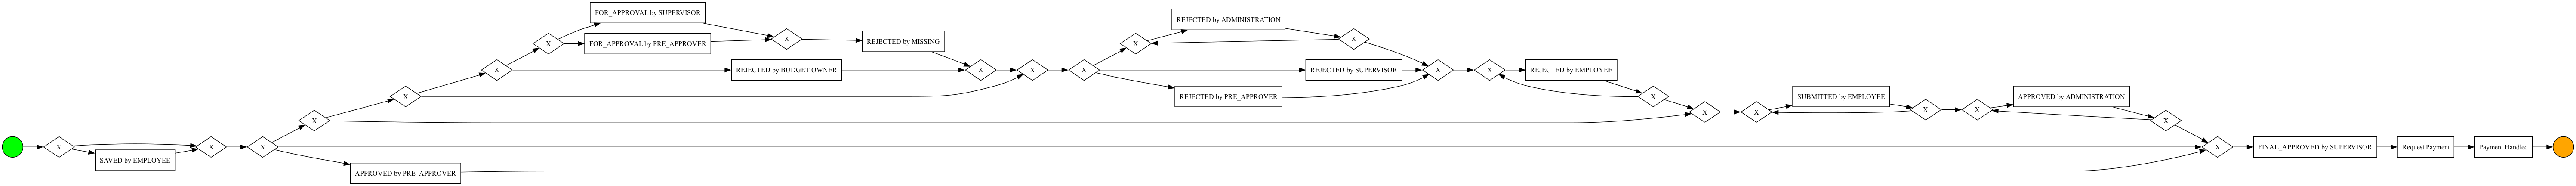

In [170]:
bpmn_model = pm4py.discover_bpmn_inductive(
    log=log,
    noise_threshold=.7,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_bpmn(bpmn_model)

## Statistics

TBD